In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm

C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('../dataset/train.csv',sep=',').dropna()
dest = pd.read_csv('../dataset/destinations.csv')
df = df.sample(frac=0.01,random_state=99)
df.shape

(241179, 24)

探索性分析

C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\jianghaitao1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


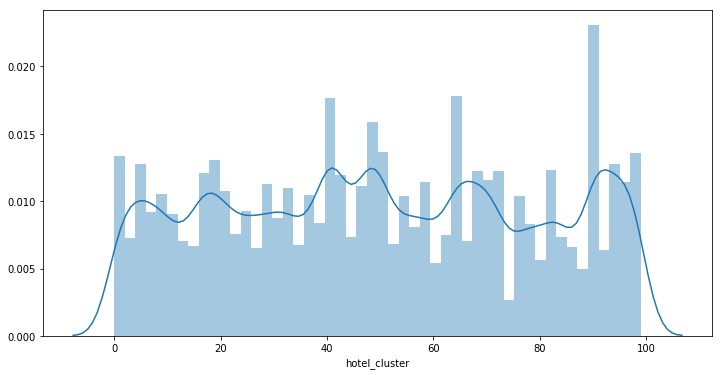

In [3]:
plt.figure(figsize=(12, 6))
sns.distplot(df['hotel_cluster'])

特征工程

In [4]:
from datetime import datetime


def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass


def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass


def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [5]:
# 处理时间格式的列
from datetime import datetime
df['date_time_year'] = pd.Series(df.date_time, index=df.index)
df['date_time_month'] = pd.Series(df.date_time, index=df.index)
df.date_time_year = df.date_time_year.apply(lambda x: get_year(x))
df.date_time_month = df.date_time_month.apply(lambda x: get_month(x))
del df['date_time']

In [6]:
# 处理srch_ci列
df['srch_ci_year'] = pd.Series(df.srch_ci, index=df.index)
df['srch_ci_month'] = pd.Series(df.srch_ci, index=df.index)
# convert year & months to int
df.srch_ci_year = df.srch_ci_year.apply(lambda x: get_year(x))
df.srch_ci_month = df.srch_ci_month.apply(lambda x: get_month(x))
# remove the srch_ci column
del df['srch_ci']

In [7]:
# 处理srch_co列
df['srch_co_year'] = pd.Series(df.srch_co, index=df.index)
df['srch_co_month'] = pd.Series(df.srch_co, index=df.index)
# convert year & months to int
df.srch_co_year = df.srch_co_year.apply(lambda x: get_year(x))
df.srch_co_month = df.srch_co_month.apply(lambda x: get_month(x))
# remove the srch_co column
del df['srch_co']

初步分析

In [8]:
df.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.036120
site_name                   -0.027497
hotel_country               -0.023837
is_booking                  -0.022898
user_location_country       -0.020239
srch_destination_id         -0.016736
srch_co_month               -0.005874
srch_rm_cnt                 -0.005570
srch_ci_month               -0.005015
date_time_month             -0.002142
channel                     -0.001386
date_time_year              -0.000435
cnt                          0.000378
hotel_continent              0.000422
user_location_city           0.001241
user_id                      0.003891
orig_destination_distance    0.006084
user_location_region         0.006927
srch_ci_year                 0.008562
is_mobile                    0.008788
srch_co_year                 0.009287
posa_continent               0.012180
srch_adults_cnt              0.012407
srch_children_cnt            0.014901
hotel_market                 0.022149
is_package                   0.047598
hotel_cluste

策略

In [9]:
pieces = [df.groupby(['srch_destination_id', 'hotel_country', 'hotel_market', 'hotel_cluster'])[
    'is_booking'].agg(['sum', 'count'])]
agg = pd.concat(pieces).groupby(level=[0, 1, 2, 3]).sum()
agg.dropna(inplace=True)
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
4                   7             246          22               0      1
                                               29               0      1
                                               30               0      1
                                               32               1      2
                                               43               0      1

In [10]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0, 1, 2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()

srch_destination_id  hotel_country  hotel_market  hotel_cluster  sum  \
0                    4              7           246             22  0.0   
1                    4              7           246             29  0.0   
2                    4              7           246             30  0.0   
3                    4              7           246             32  1.0   
4                    4              7           246             43  0.0   

   count  sum_and_cnt  
0  0.125     0.073171  
1  0.125     0.073171  
2  0.125     0.073171  
3  0.250     0.560976  
4  0.125     0.073171

In [11]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
agg_pivot.head()

hotel_cluster  srch_destination_id  hotel_country  hotel_market   0   1   2  \
0                                4              7           246 NaN NaN NaN   
1                                8             50           416 NaN NaN NaN   
2                               11             50           824 NaN NaN NaN   
3                               14             27          1434 NaN NaN NaN   
4                               16             50           419 NaN NaN NaN   

hotel_cluster   3   4   5   6 ...  90        91  92  93  94  95  96  97  98  \
0             NaN NaN NaN NaN ... NaN       NaN NaN NaN NaN NaN NaN NaN NaN   
1             NaN NaN NaN NaN ... NaN  0.025210 NaN NaN NaN NaN NaN NaN NaN   
2             NaN NaN NaN NaN ... NaN       NaN NaN NaN NaN NaN NaN NaN NaN   
3             NaN NaN NaN NaN ... NaN       NaN NaN NaN NaN NaN NaN NaN NaN   
4             NaN NaN NaN NaN ... NaN  0.344828 NaN NaN NaN NaN NaN NaN NaN   

hotel_cluster  99  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 103 columns]

In [12]:
df = pd.merge(df, dest, how='left', on='srch_destination_id')
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
df.fillna(0, inplace=True)
df.shape

(241179, 276)

实现算法

In [13]:
df = df.loc[df['is_booking'] == 1]

In [14]:
X = df.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = df.hotel_cluster

In [16]:
# 朴素贝叶斯
from sklearn.naive_bayes import GaussianNB
clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(clf, X, y, cv=10))

0.10347912437041926

In [17]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))

0.25631461834732266

In [18]:
# 随机森林
clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=273,max_depth=10,random_state=0))
np.mean(cross_val_score(clf, X, y, cv=10))

0.24865023372782996

In [ ]:
# 多分类逻辑回归
from sklearn.linear_model import LogisticRegression
clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(clf, X, y, cv=10))

In [ ]:
# 支持向量机，很耗时，但效果更好
from sklearn import svm
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(clf, X, y, cv=10))